1. __выравнивание прочтений на геном__
2. __перевод sam в bam файл__
3. __подсчет кол-ва выравненных прочтений__
4. __подсчет статистистик прочтений__

####  Данные ONT
1. minimap2 -ax map-ont reference.fasta ONT_2D.fastq.gz > ONT.sam
2. samtools view -S -b ONT.sam > ONT.bam
3. samtools flagstat ONT.bam > flagstat_ONT.txt
4. samtools stats -r reference.fasta ONT.bam > ONT.stats 




In [210]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pysam
import pandas as pd
from tqdm import tqdm

In [122]:
with open('reference.fasta') as fi:
    ref = fi.readlines()[1:]
    fi.close()
ref = ''.join([item.strip() for item in ref])

### A) Кол-во выровненных прочтений:
#### 29565 + 0 mapped (92.09% : N/A)
#### 28272 + 0 primary mapped (91.76% : N/A)

### B) Распределение длин вставок

In [2]:
id_distr = pd.read_csv('./ID_ONT.txt', sep = '\t', header = None)

In [3]:
id_distr.columns = ['length', 'number_insertions', 'number_deleted']

In [4]:
id_distr.head()

,length,number_insertions,number_deleted
0,1,525344,1897085
1,2,207341,758942
2,3,81779,368504
3,4,31719,145775
4,5,14057,71921


In [5]:
val = np.log(id_distr['number_insertions'].values+1) 

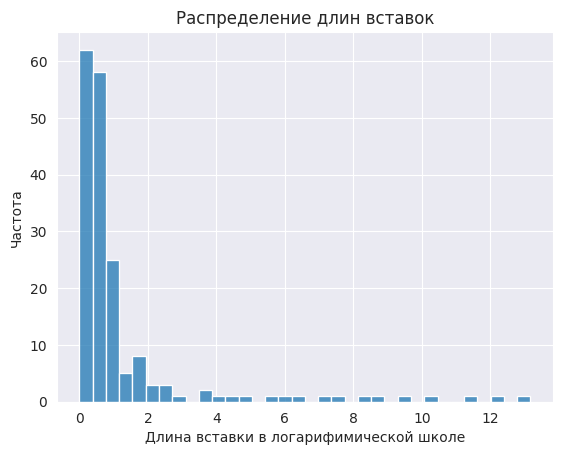

In [11]:
sns.histplot(val);
plt.xlabel("Длина вставки в логарифимической школе")
plt.ylabel("Частота")
plt.title(f"Распределение длин вставок")
plt.show()

### C) ДОля ошибок

__error rate:	8.109271e-02__

##### __D) Распределение типов замен__:

Перед тем как смотреть изменение в каждой позиции, необходимо сортировать bam файл относительно референса:


#### samtools sort ONT.bam -o sorted_ONT.bam

Вычисление праспределений замен:
### Буду использовать pysam для чтения bam файлов
Информация о изменении в основании в атрибуте cigartuples

In [202]:
bam_file = pysam.AlignmentFile("./sorted_ONT.bam", "rb")
reads = [read for read in bam_file]

In [203]:
sam_file = pysam.AlignmentFile("./ONT.sam", "r")

In [204]:
def count_substitution(sam_file):
    substitution_counts = {('A', 'C'): 0, ('A', 'G'): 0, ('A', 'T'): 0,
                       ('C', 'A'): 0, ('C', 'G'): 0, ('C', 'T'): 0,
                       ('G', 'A'): 0, ('G', 'C'): 0, ('G', 'T'): 0,
                       ('T', 'A'): 0, ('T', 'C'): 0, ('T', 'G'): 0, 'deletions': 0, 'inserts': 0}
    for read in sam_file:
        seq_read = read.query_sequence
        if seq_read:
            pos = read.get_aligned_pairs()
            for item in pos:
                if None not in item:
                    query_idx, ref_idx = item
                    ref_base = ref[ref_idx]
                    query_base = seq_read[query_idx]
                    if query_base != ref_base:
                        substitution_counts[(query_base, ref_base)] += 1
                else:
                    if item[0] == None:
                        substitution_counts['deletions'] += 1
                    else:
                        substitution_counts['inserts'] += 1
    return substitution_counts
        
    




In [205]:
substitution_counts = count_substitution(sam_file)
                    

In [208]:
counts_df = pd.DataFrame(list(substitution_counts.items()), columns=['mutation', 'count'])

In [209]:
counts_df

,mutation,count
0,"(A, C)",137046
1,"(A, G)",319761
2,"(A, T)",107765
3,"(C, A)",112963
4,"(C, G)",91353
5,"(C, T)",372780
6,"(G, A)",368487
7,"(G, C)",85027
8,"(G, T)",111447
9,"(T, A)",105373


__E) Покрытие__


In [16]:
from collections import defaultdict

In [17]:
def calculate_coverage(reads):
    stats = defaultdict(int)  # словарь позиция в референсе - кол-во покрытий
    for read in reads:
        pairs = read.get_aligned_pairs()
        for align in pairs:
            _, idx_ref = align
            if idx_ref:
                stats[idx_ref] += 1
    return stats

In [18]:
stats = calculate_coverage(reads)

In [19]:
def plot_func(stats, name):
    sns.histplot(stats.values(), bins = 100)
    plt.xlabel("Позиция в геноме (в bin)")
    plt.ylabel("Кол-во покрытый")
    plt.title(f"Покрытие референсного генома {name}")
    plt.show()
    mean_coverage = np.array(list(stats.values())).mean()
    print(f'Среднее покрытие на позицию {mean_coverage}')

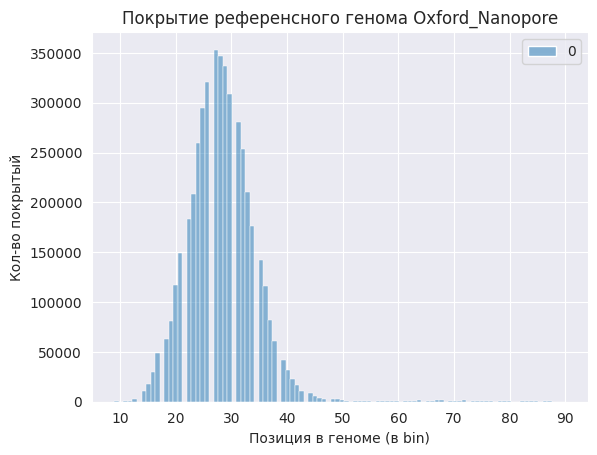

Среднее покрытие на позицию 28.341344025463858


In [20]:
plot_func(stats, 'Oxford_Nanopore')

####  Данные Pacbio
1. minimap2 -ax map-ont reference.fasta ONT_2D.fastq.gz > pacbio_align.sam
2. samtools view -S -b pacbio_align.sam > pacbio_align.bam
3. samtools flagstat pacbio_align.bam >> flagstat_pacbio.txt
4. samtools stats -r reference.fasta pacbio_align.bam >> pacbio_align.stats


#### A) Кол-во выровненных прочтений:
##### 51199 + 0 mapped (98.31% : N/A)
##### 40565 + 0 primary mapped (97.87% : N/A)


### B) Распределение длин вставок

In [27]:
id_distr = pd.read_csv('./ID_pacbio.txt', sep = '\t', header = None)
id_distr.columns = ['length', 'number_insertions', 'number_deleted']

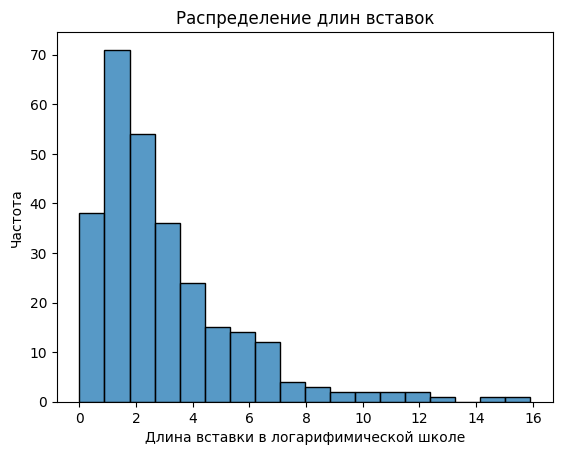

In [28]:
val = np.log(id_distr['number_insertions'].values+1)
sns.histplot(val);
plt.xlabel("Длина вставки в логарифимической школе")
plt.ylabel("Частота")
plt.title(f"Распределение длин вставок")
plt.show()

### C) Доля ошибок

error rate:	1.458431e-01	# mismatches / bases mapped (cigar)

__D) Распределение замен__:

In [211]:
# open the sam/bam file
sam_file = pysam.AlignmentFile("./pacbio_align.sam", "r")
reads = [read for read in sam_file]


In [220]:
substitution_counts = count_substitution(sam_file)

In [222]:
counts_df = pd.DataFrame(list(substitution_counts.items()), columns=['mutation', 'count'])
counts_df

,mutation,count
0,"(A, C)",464039
1,"(A, G)",327302
2,"(A, T)",289533
3,"(C, A)",357476
4,"(C, G)",420393
5,"(C, T)",311896
6,"(G, A)",309921
7,"(G, C)",418981
8,"(G, T)",362955
9,"(T, A)",289389


__E. Распределение покрытий__

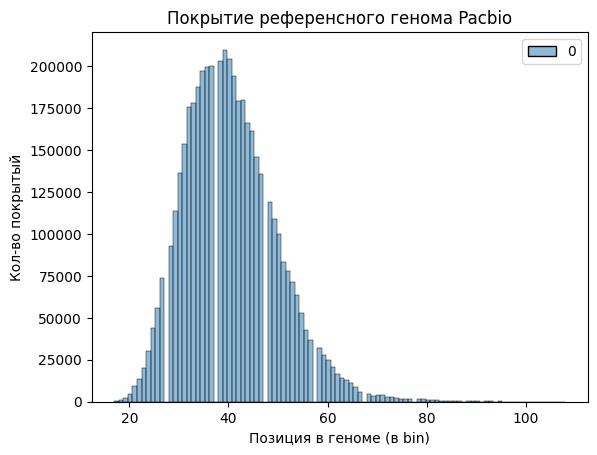

Среднее покрытие на позицию 40.523643471502524


In [18]:
stats = calculate_coverage(reads)
plot_func(stats, 'Pacbio')

#### Покрытие ридов Pacbio показало лучшие результаты

#### Делеции в данных Pacbio оказалось больше, чем в ONT